# PCA cross sky subtraction for HETDEX and other spectroscopic datasets

This notebook introduces the concept of a (cross) PCA skysubtraction.

The `cross` refers to the technique to use sky information from other sources (other fibers, other IFUs or an average of the entire focal plane) to subtract the sky of another fiber. 

Input to all of this are rebinned pickle files for the sky spectra and the fiber to finer troughputs. These are precomputed from the multifits files.


Note: this is all on a single fiber still

In [1]:
# go wide screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np

from astropy.io import fits
from astropy.stats import biweight_location
from sklearn.decomposition import PCA
import pickle
from matplotlib import pyplot as plt
% matplotlib inline
from astropy.visualization import (MinMaxInterval, ZScaleInterval, SqrtStretch, AsinhStretch, LinearStretch, LogStretch,
                                   ImageNormalize)

from collections import OrderedDict

import spectrum

In [3]:
def load_skys(ff,which="sky_spectrum"):
    """
    Loeads the rebinned an pickeled skys into a convenient datastructure.
    """
    skys = OrderedDict()
    shotids = OrderedDict()
    N = len(ff)
    sff = []
    for i,f in enumerate(ff):
        if i % 100 == 0:
            print("loading {} out of {}.".format(i,N))
        shotid = f.split("/")[2]
        exp = f.split("/")[3]
        try:
            ww,rb = pickle.load( open(f,'rb'), encoding='iso-8859-1' )
            skys[(shotid,exp)] = rb[which]/rb["fiber_to_fiber"] 
            shotids[(shotid,exp)] = f
        except:
            print("Error loading {}.".format(f))
            pass
    print("starting wl = ", ww[0], "A")
    return ww, skys, sff

In [4]:
# Here we read which shots shoudl be used for the computation 
# of the PCA comonents. These may or may not contain the shot for which we actually want to execute the sky subtraction.
fn_shotlist_pca = "data/shotlist_pca_COSMOSA.txt"
IFU = "022"
AMP = "LL"
FIBER = 75

with open(fn_shotlist_pca, 'r') as f:
    s = f.read()
shotlist_PCA = s.split()


In [5]:
# Find all precomputed, rebinned pickle files and load them.
ff=[]
for shot in shotlist_PCA:
    if shot.startswith("#"):
        continue
    cmd = "ls data/rebin/{}/exp0?/multi_???_{}_???_{}_rebin.pickle".format(shot, IFU, AMP)
    tmp = !$cmd
    ff += tmp

# and actually load the data.
skys = OrderedDict()
ww,skys[(IFU,AMP)],sff = load_skys(ff,which="sky_spectrum")

loading 0 out of 366.
loading 100 out of 366.


/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in true_divide


loading 200 out of 366.
loading 300 out of 366.
starting wl =  3494.74 A


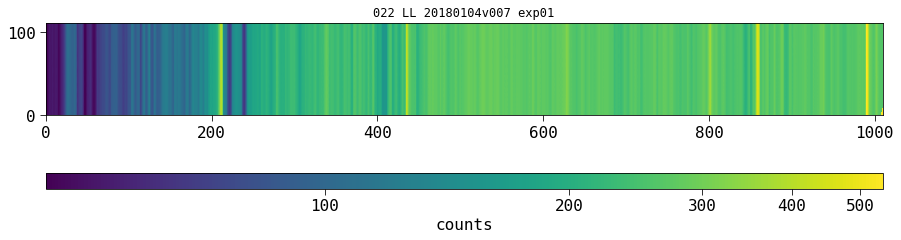

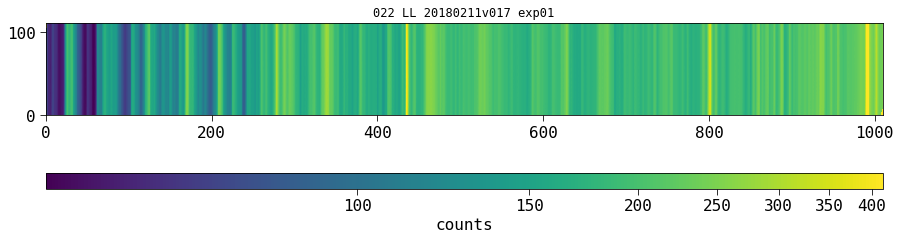

In [6]:
# Plot a few random spectra
def plotSpec(skys, IFU, amp, shot, exp):
    
    image = skys[(IFU, amp)][(shot, exp)]

    # Create an ImageNormalize object
    norm = ImageNormalize(image, interval=ZScaleInterval(),
                          stretch=AsinhStretch())

    # or equivalently using positional arguments
    # norm = ImageNormalize(image, MinMaxInterval(), SqrtStretch())

    # Display the image
    fig = plt.figure(figsize=[15,7])
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(image, origin='lower', norm=norm)
    cb = fig.colorbar(im, orientation='horizontal', aspect=(50))
    cb.set_label("counts")
    
    plt.title("{} {} {} {}".format(IFU, amp, shot, exp))

IFU, amp, shot, exp = '022', 'LL', '20180104v007', 'exp01'
plotSpec(skys, IFU, amp, shot, exp)

IFU, amp, shot, exp = '022', 'LL', '20180211v017', 'exp01'
plotSpec(skys, IFU, amp, shot, exp)

In [7]:
# "A" generically stands for the data that we use as input for the sky reconstruction.
# here it is ALL fibers in ifu IFU and amp AMP
XA = np.array( [ biweight_location( skys[(IFU, AMP)][k], axis=0 )  for k in skys[(IFU, AMP)] ] )

# "B" generically stands for the spectrum for which we want to reconstruc the sky from the PCA components.
# Here we select fiber 75 in IFU 022 and lower left amp (LL).
XB = np.array( [skys[(IFU, AMP)][k][FIBER] for k in skys[(IFU, AMP)] ] )

/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 3 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/astropy/stats/biweight.py:117: RuntimeWarning: invalid value encountered in greater_equal
  mask = (np.abs(u) >= 1)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 2 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 6 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median for 7 results
  r = func(a, **kwargs)
/Users/mxhf/.pyenv/versions/anac

In [8]:
# hack to homogenize lengths, the rebinning does make sure
# that the wavelength grid always stars at the same wavelength
# but not necessarey, end at the same ( ther may be a few pixel more or less)
N = np.min([XA.shape[1], XB.shape[1], ww.shape[0]])
ww = ww[:N]
XA = XA[:,:N]
XB = XB[:,:N]
# selct wavelength subrange
#wstart = 4626.668686
#wend  = 5400.
wstart = 3495.
wend = 5493.
wend = 5454.76 # masking out one bad feature at the red end

#ww = 
ii = (ww >= wstart) * (ww <= wend)

wwcut = ww[ii]
XAcut = XA[:,ii]
XBcut = XB[:,ii]

300 of 366 survive cut.


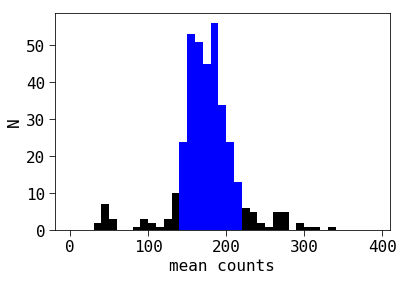

In [9]:
# here we apply cuts to reject sky spectra that have 
# usually high (or low) fluxes. Probably those were taken in bad condition.
#mm = np.mean( XAcut[:,125:225], axis=1)
mm = np.mean( XAcut[:,450:600], axis=1)

plt.hist(mm,bins=np.arange(0,400,10))


start, stop = 140., 220.
#start, stop = 90., 350.

jj = (mm > start) * (mm < stop)

plt.hist(mm[jj],bins=np.arange(0,400,10))

print("{} of {} survive cut.".format(np.sum(jj),len(jj)))
plt.xlabel("mean counts")
plt.ylabel("N")


kk = jj # here we could apply further filters

In [10]:
# maintain memory of which shots actually entered the PCA computation
def shotNum(shotid, exp):
    #print(shotid)
    return int(shotid.replace("v","") + exp[-2:])
    
#s = list( skys[(IFU,AMP)].keys() )[0]
#shotNum( s[0], s[1] )


shotNumA = []
for k,s in zip( kk, skys[(IFU,AMP)].keys()):
    if k:
        shotNumA.append(shotNum( s[0], s[1] ))

shotNumA = np.array( shotNumA )       
len(shotNumA)

300

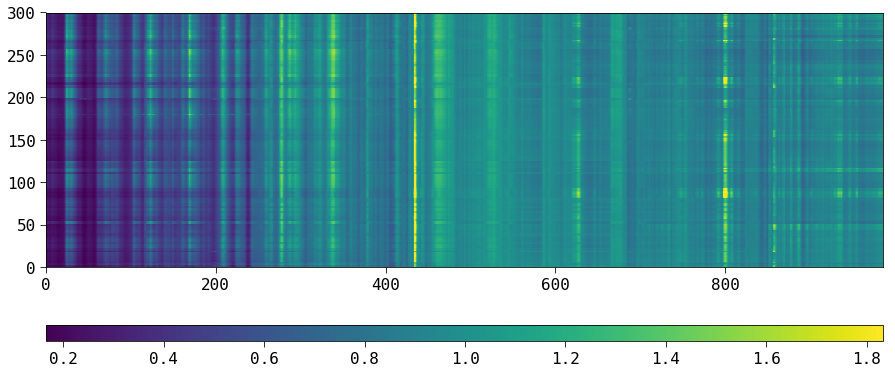

In [11]:
# Lets see what we got, plot all spectra that will
# enter the PCA computation.

image = (XAcut.T/mm).T[jj*kk]

# Create an ImageNormalize object
norm = ImageNormalize(image, interval=ZScaleInterval(),
                      stretch=LinearStretch())

# Display the image
fig = plt.figure(figsize=[15,7])
ax = fig.add_subplot(1, 1, 1)
im = ax.imshow(image, origin='lower', norm=norm)
fig.colorbar(im, orientation='horizontal', aspect=(50))

In [12]:
# finally really apply the filter
XAcut = XAcut[jj*kk]
XBcut = XBcut[jj*kk]

In [13]:
# This is for testing:
# Add synthetic lines in every B - spectrum
# random wavelength
# random sigma (3.5 - 10. A)
# random amplitude (20 - 100. A)

np.random.seed(42)
if True:
    #generic gaussian
    def gauss(mu, sigma, x):
        return 1./(sigma * np.sqrt(2. * np.pi) ) * np.exp( -(x-mu)**2./(2. * sigma**2.))

    gg = []
    
    for i in range(XBcut.shape[0]):
        mu = np.random.uniform()* (wwcut[-1] - wwcut[0]) + wwcut[0]
        sigma = np.random.uniform() * 10. + 3.5
        A = np.random.uniform() * 90. + 50.

        g = A*gauss(mu, sigma, wwcut)

        XBcut[i]  = XBcut[i] + g
        
        gg.append(g)

In [14]:
# This is the first essential step of the PCA, we subtract the respective sample mean
MA = np.mean(XAcut,axis=0)
XAmean = XAcut - MA

MB = np.mean(XBcut,axis=0)
XBmean = XBcut - MB

In [15]:
np.std(XAmean)

20.86512476062447

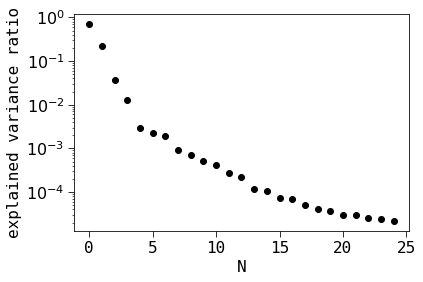

In [16]:
# Plot to help estimate the number of required PCA components.
# variance vs. number of components.

n_components = 25
pcaA = PCA(n_components=n_components)
pcaA.fit(XAmean)
plt.plot(pcaA.explained_variance_ratio_, 'o')  
plt.xlabel("N")
plt.ylabel("explained variance ratio")
plt.yscale('log')

In [17]:
# project pca componets onto
# mean shifted input spectra
ccA = np.inner(XAmean,pcaA.components_)

# reconstruct pca comonents through linear combination
rcA = np.matmul( XAmean.T, ccA).T
# they wont be normalized yet
for i,cA in enumerate(rcA):
    rcA[i] = rcA[i]/np.linalg.norm(rcA[i])

#rc = rc/np.linalg.norm(rc,axis=1)

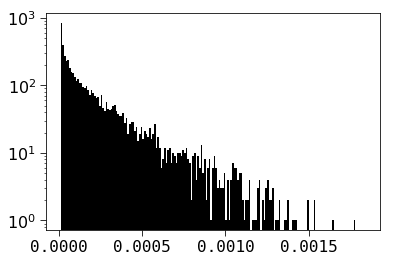

In [18]:
# make sure the result is the same
(np.abs( rcA - pcaA.components_) < 1e-6).all()

dd = np.abs( rcA - pcaA.components_).flatten()

__ = plt.hist(np.abs( rcA - pcaA.components_).flatten()  , bins=np.arange( dd.min() ,dd.max() , 1e-5)[1:] )
plt.yscale("log")

/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


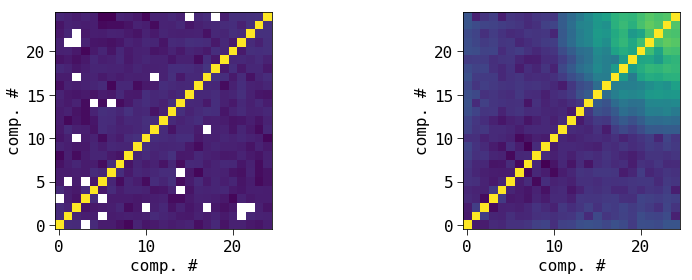

In [19]:
# the othogonality plot
if True:
    f = plt.figure(figsize=[12,4])
    plt.subplot(121)
    plt.imshow(  np.log( np.abs(np.matmul(pcaA.components_, pcaA.components_.T ))), origin='bottom')
    plt.xlabel("comp. #")
    plt.ylabel("comp. #")
    plt.subplot(122)
    plt.imshow( np.log( np.abs(np.matmul(rcA, rcA.T )) ), origin='bottom')
    plt.xlabel("comp. #")
    plt.ylabel("comp. #")
    f.tight_layout()

In [20]:
np.abs( rcA - pcaA.components_).flatten().max()

0.0018499845894677687

In [21]:
# compute projection of input spectra onto PCA basis
tA = pcaA.transform(XAmean)

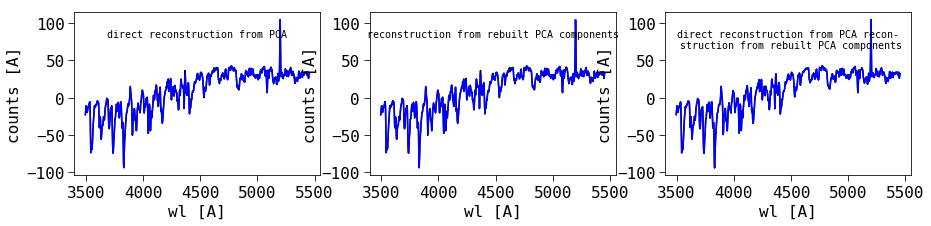

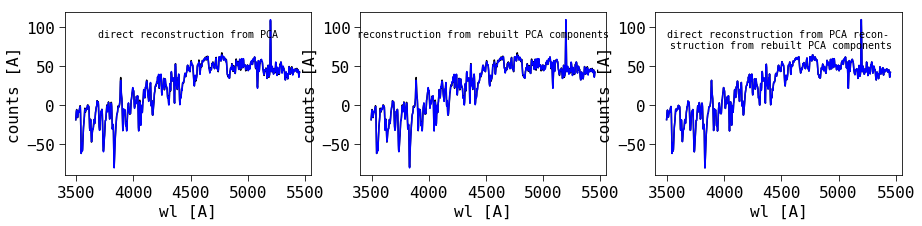

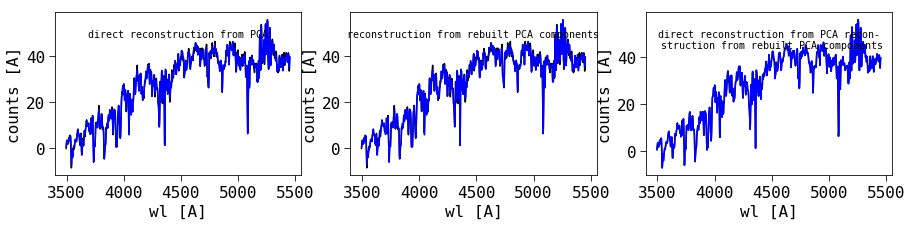

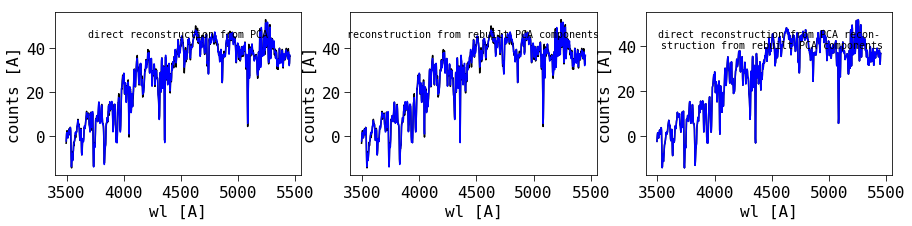

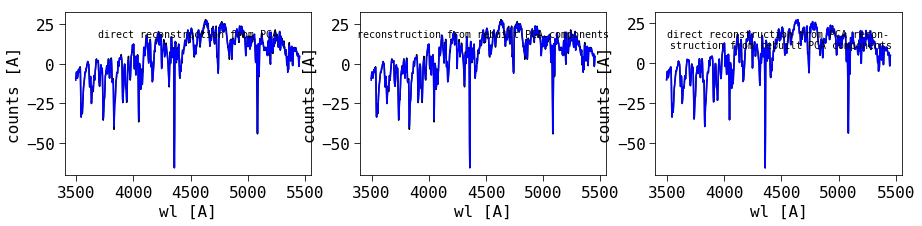

In [22]:
# make sure we can reconstruct the spectra from the
# actual principal components but also from the reconstructed ones
for i in range(5):
    f = plt.figure(figsize=[15,3])
    # plotting input mean spectra and
    # direct reconstruction from PCA
    ax1 = plt.subplot(131)
    plt.plot( wwcut, XAmean[i] )
    # next two lines must have identical result
    plt.plot( wwcut, np.inner(tA, pcaA.components_.T)[i] )
    #plt.plot( wwcut, pcaA.inverse_transform(tA)[i] )
    plt.xlabel("wl [A]")
    plt.ylabel("counts [A]")
    plt.text(.5,.9,"direct reconstruction from PCA", transform=ax1.transAxes, ha='center',va='top')

    ax2 = plt.subplot(132)
    # plotting input mean spectra and
    #  reconstruction from rebuilt PCA components
    plt.plot( wwcut, XAmean[i] )
    plt.plot( wwcut, np.inner(tA, rcA.T)[i] )
    plt.xlabel("wl [A]")
    plt.ylabel("counts [A]")
    plt.text(.5,.9,"reconstruction from rebuilt PCA components", transform=ax2.transAxes, ha='center',va='top')

    ax3 = plt.subplot(133)
    # plot
    # direct reconstruction from PCA
    # and reconstruction from rebuilt PCA components
    # (but not input spectra)
    plt.plot( wwcut, np.inner(tA, pcaA.components_.T)[i] )
    plt.plot( wwcut, np.inner(tA, rcA.T)[i] )
    plt.xlabel("wl [A]")
    plt.ylabel("counts [A]")
    plt.text(.5,.9,"direct reconstruction from PCA recon-\n struction from rebuilt PCA components", transform=ax3.transAxes, ha='center',va='top')

In [23]:
# This reconstructs pca components of B through linear combination of spectra from B
# BUT using projection from A
rcB = np.matmul( XBmean.T, ccA).T
# they wont be normalized yet
for i,cB in enumerate(rcB):
    rcB[i] = rcB[i]/np.linalg.norm(rcB[i])

/Users/mxhf/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


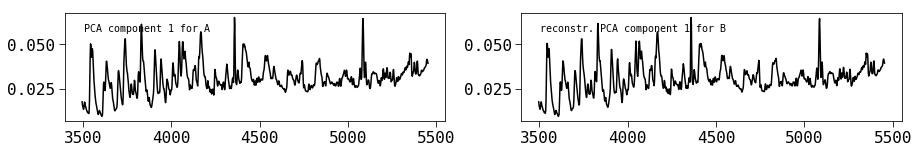

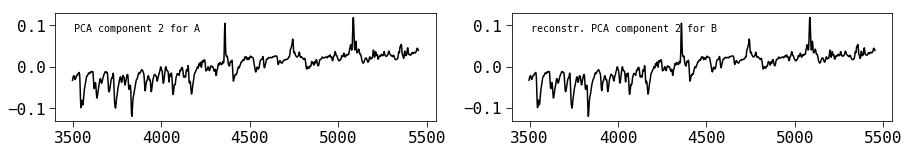

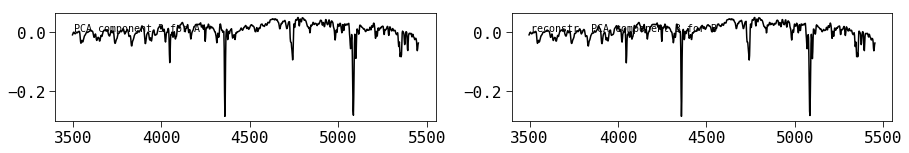

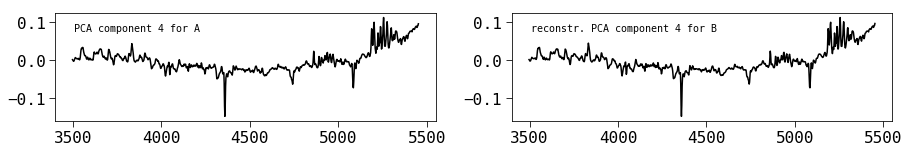

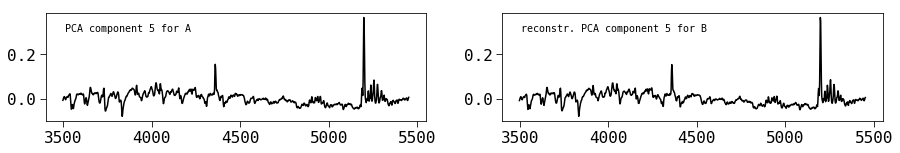

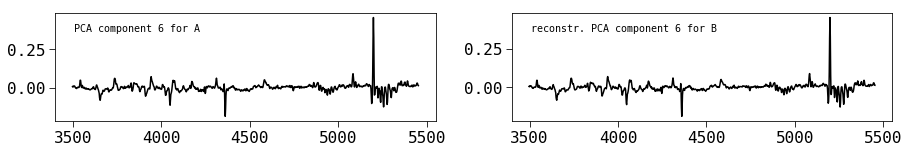

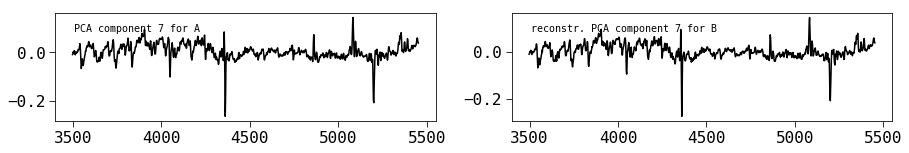

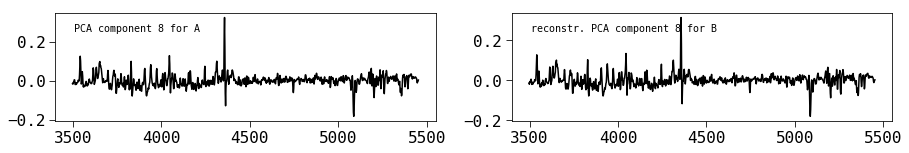

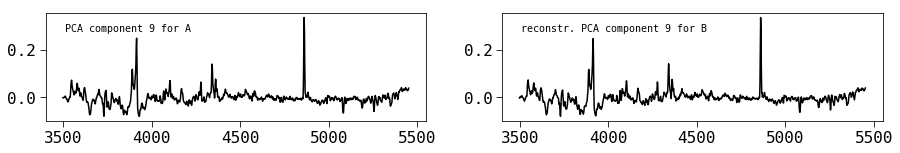

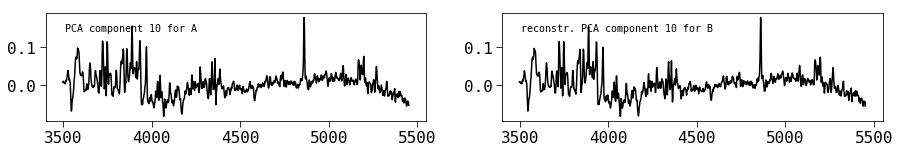

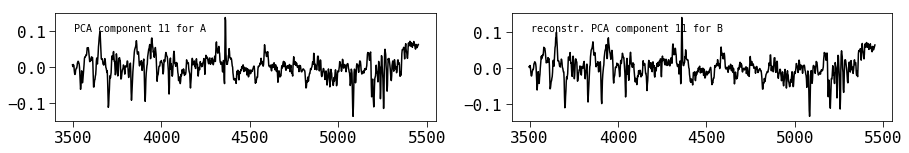

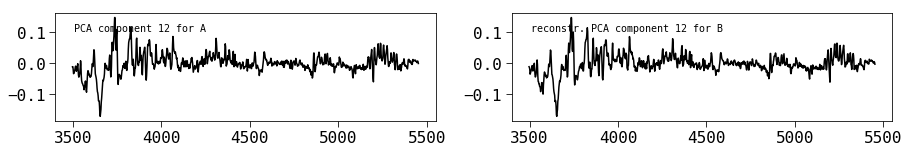

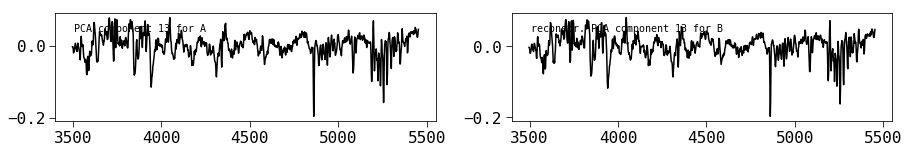

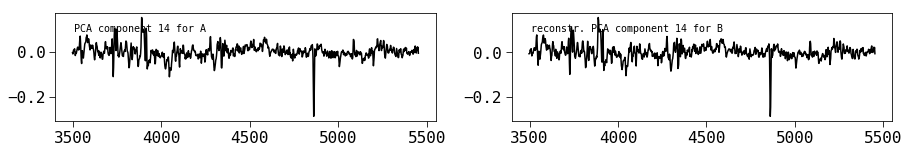

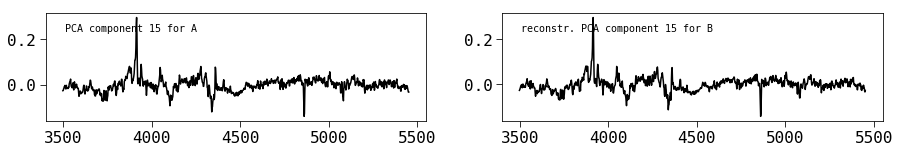

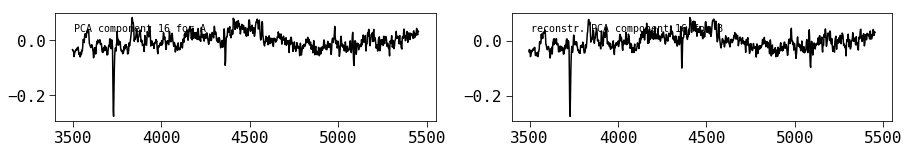

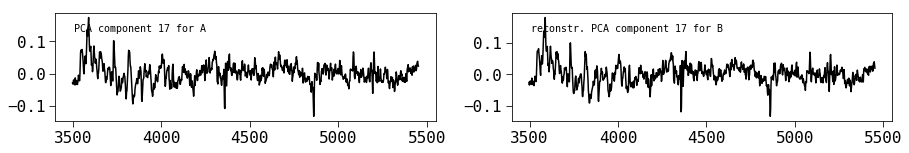

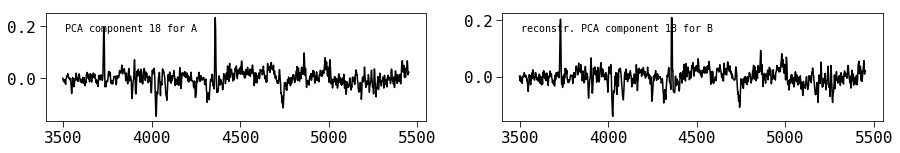

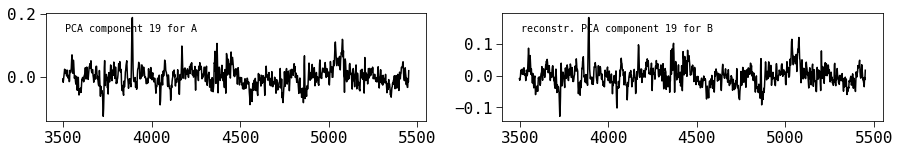

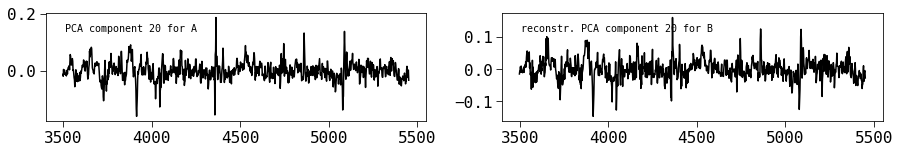

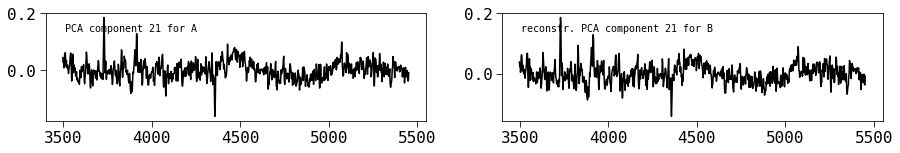

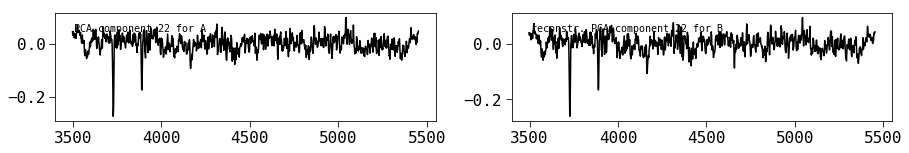

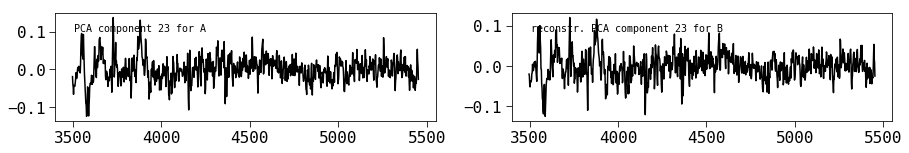

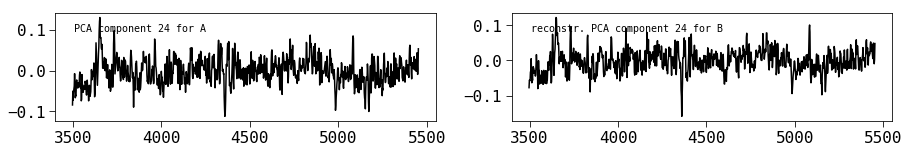

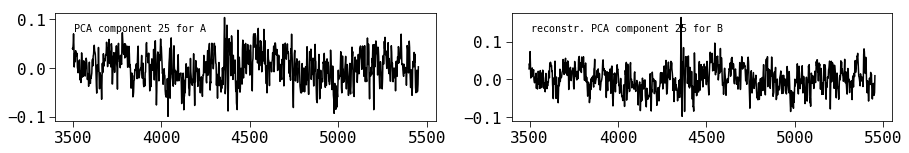

In [24]:
# plot PCA components for A and B
for i in range(pcaA.n_components):
    f = plt.figure(figsize=[15,2])
    
    ax1 = plt.subplot(121)
    plt.plot( wwcut, pcaA.components_[i] )
    plt.text(.05,.9, "PCA component {} for A".format(i+1), transform=ax1.transAxes, va='top', ha='left')
    ax2 = plt.subplot(122)
    plt.plot( wwcut, rcB[i] )    
    plt.text(.05,.9, "reconstr. PCA component {} for B".format(i+1), transform=ax2.transAxes, va='top', ha='left')

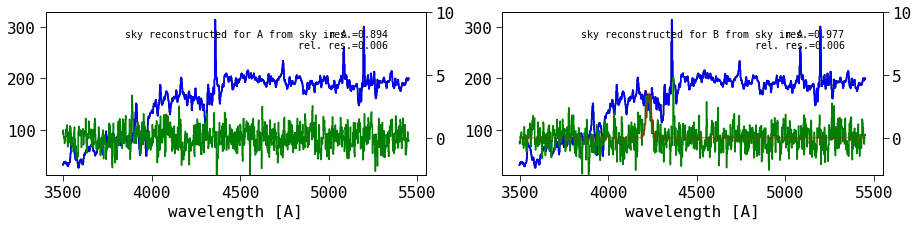

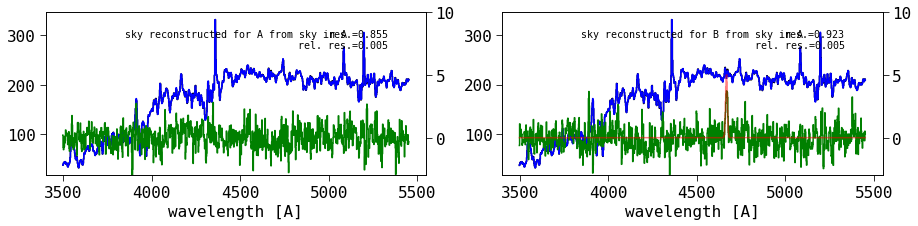

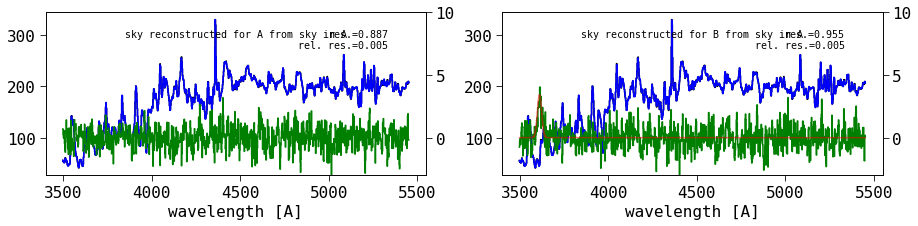

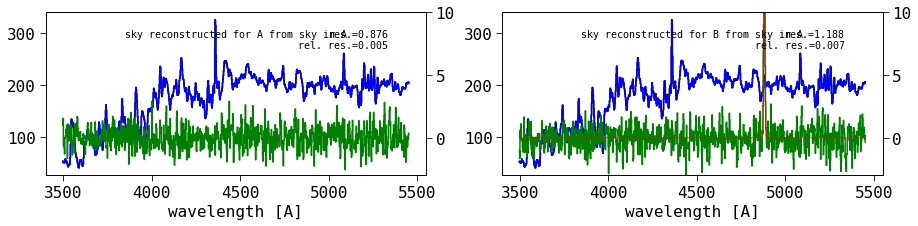

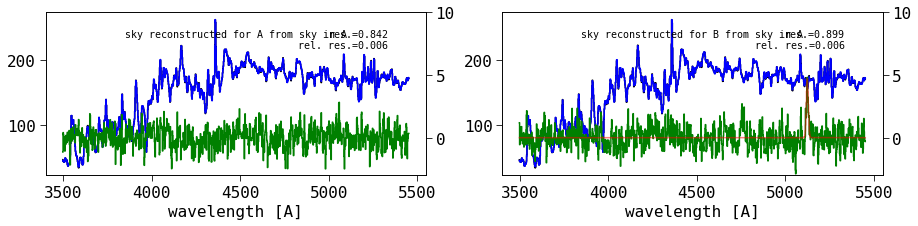

In [25]:
# Finally, check how well we are doing:
# Make sure we can reconstuct the spectra from the
# actual principal components for A but also from the reconstructed ones for B
for i in range(5):
    f = plt.figure(figsize=[15,3])
    ax = plt.subplot(121)
    
    y  = XAmean[i] + MA
    ry = np.inner(tA, pcaA.components_.T)[i] + MA
    res = ry-y
    plt.plot(wwcut,  y , drawstyle='steps-mid' )
    plt.plot(wwcut, ry , drawstyle='steps-mid' )
    plt.xlabel("wavelength [A]")
    plt.twinx()
    plt.plot(wwcut,   res, 'g-' , drawstyle='steps-mid' )
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
    plt.text(.5,.9,"sky reconstructed for A from sky in A", transform=ax.transAxes, ha='center',va='top')
    

    ax = plt.subplot(122, sharex=ax)
    
    y  = XBmean[i] + MB
    ry = np.inner(tA, rcB.T)[i] + MB
    res = y-ry
    
    plt.plot(wwcut,   y , drawstyle='steps-mid' )
    plt.plot(wwcut,   ry , drawstyle='steps-mid' )
    plt.xlabel("wavelength [A]")
    plt.twinx()
    
    plt.plot(wwcut,   res, 'g-' , drawstyle='steps-mid')
    plt.ylim([-3,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')
    plt.text(.5,.9,"sky reconstructed for B from sky in A", transform=ax.transAxes, ha='center',va='top')

    plt.plot(wwcut,   gg[i], 'r-' , drawstyle='steps-mid', alpha=.5)


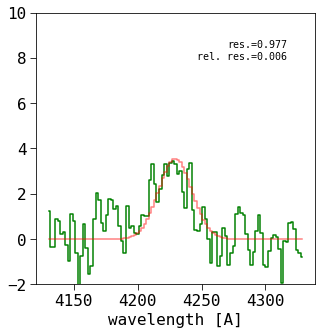

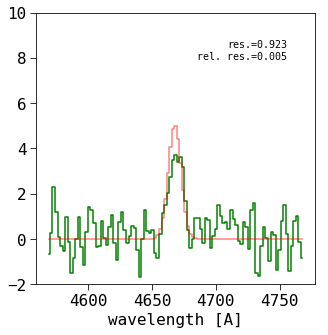

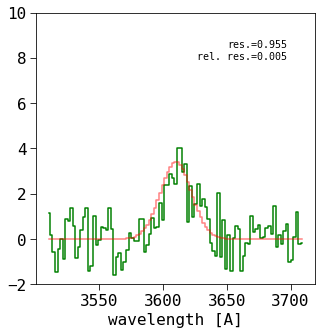

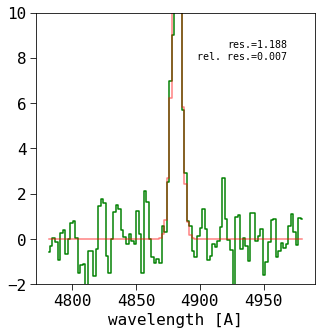

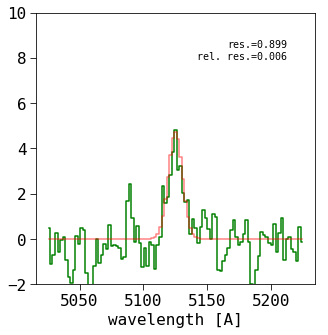

In [26]:
# Almost same as last cell, but here zoom in onto fake emission lines. Make sure they are not getting removed.
for i in range(5):
    f = plt.figure(figsize=[5,5])
    ax = plt.subplot()
    y  = XBmean[i] + MB
    ry = np.inner(tA, rcB.T)[i] + MB
    res = y-ry

    wc = wwcut[np.argmax(gg[i])]
    ii = (wwcut > (wc-100.)) * (wwcut < (wc+100.))

    plt.plot(wwcut[ii],   res[ii], 'g-' , drawstyle='steps-mid')
    plt.ylim([-2,10.])
    plt.text(0.9,0.9,"res.={:.3f}\n rel. res.={:.3f}".format(np.std(res), np.std(res)/np.abs(np.mean(y)) ), transform = ax.transAxes, ha='right',va='top')

    plt.plot(wwcut[ii],   gg[i][ii], 'r-' , drawstyle='steps-mid', alpha=.5)

    plt.xlabel("wavelength [A]")

In [1]:
# by sequential night
nightcount = 0
x = []
nights = []
for s in shotNumA:
    night = int( str(s)[:8])
    if not night in nights:
        nightcount += 1
        nights.append(night)
    #print(nightcount, night)
    x.append(nightcount)
x = np.array( x )   


# actual night/shot/exp
x = np.array(shotNumA)-2018000000000 

# shot sequence
#x = np.arange(tA.shape[0]) 

# by actual month
#x = np.array( [int( str(s)[:6]) for s in shotNumA] ) 

# by  month number
#x = np.array( [int( str(s)[4:6]) for s in shotNumA] )

NameError: name 'shotNumA' is not defined

Exceptional weights for component 0:  [2018021101702 2018021101803]


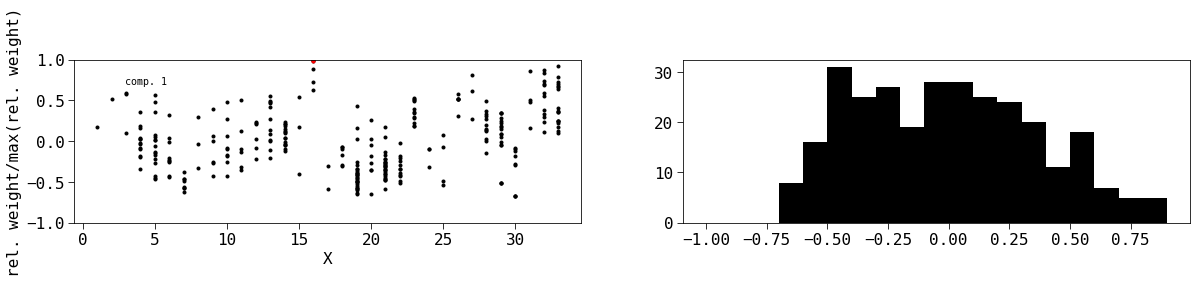

Exceptional weights for component 1:  [2018010700301 2018020801203 2018020801301]


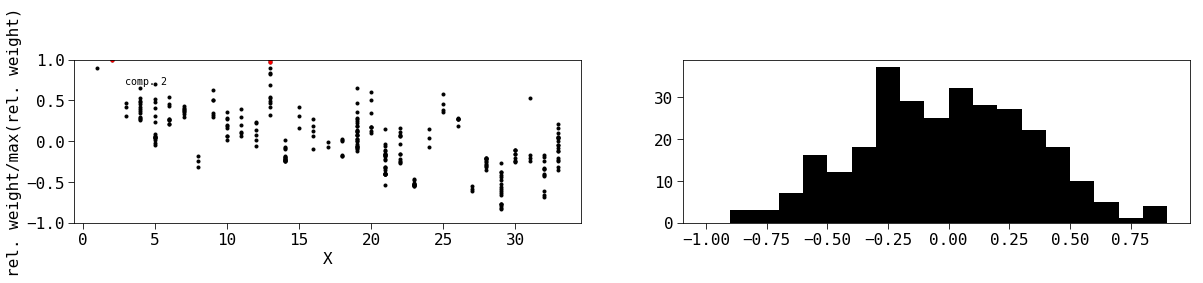

Exceptional weights for component 2:  [2018010600503 2018010700301 2018011002102 2018011002103 2018011200703
 2018011300603 2018020801203 2018020801301 2018031901301]


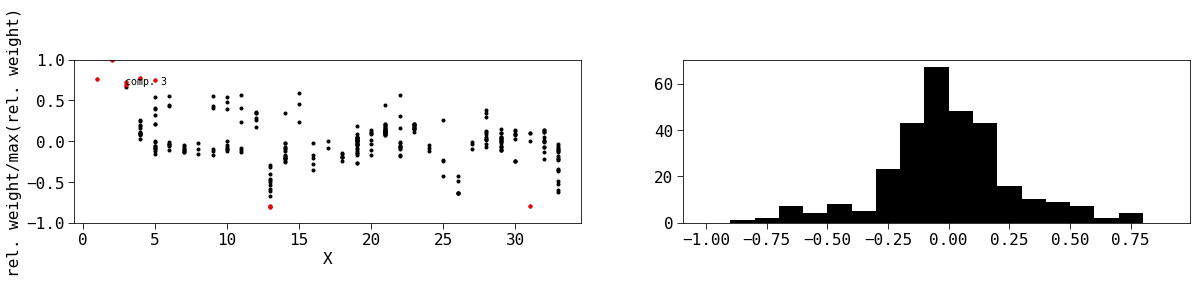

Exceptional weights for component 3:  [2018021101701 2018021101702 2018021101703 2018021101801 2018021101803
 2018032000803]


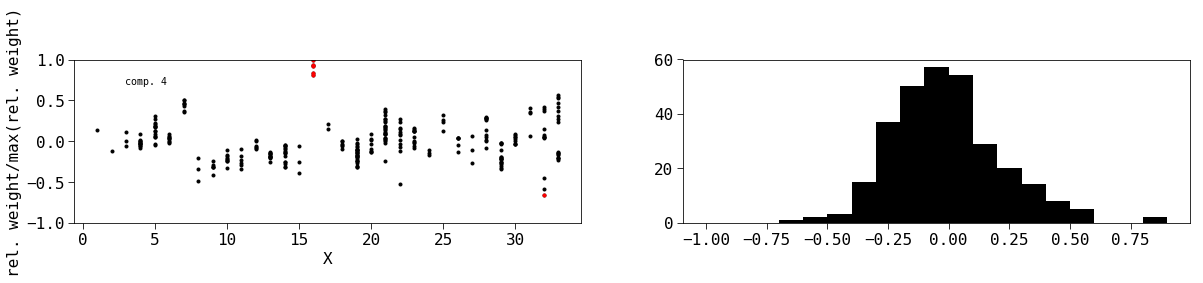

Exceptional weights for component 4:  [2018011200901 2018011501102 2018011501103 2018030700301 2018030700302
 2018031901301]


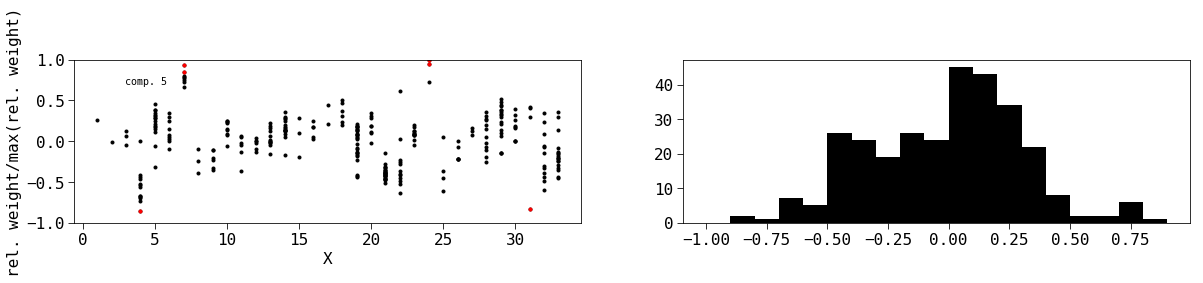

Exceptional weights for component 5:  [2018010600503 2018011300603 2018030900101 2018030900301 2018031901501
 2018031901502 2018031901503]


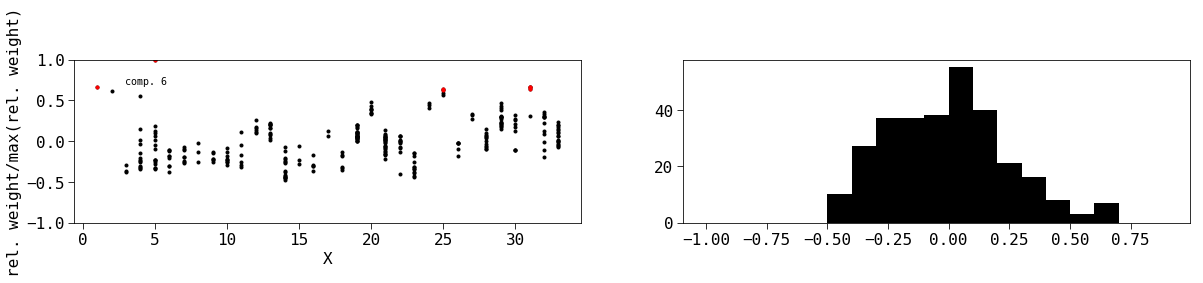

Exceptional weights for component 6:  [2018011200901 2018021501502 2018022301702 2018022301703]


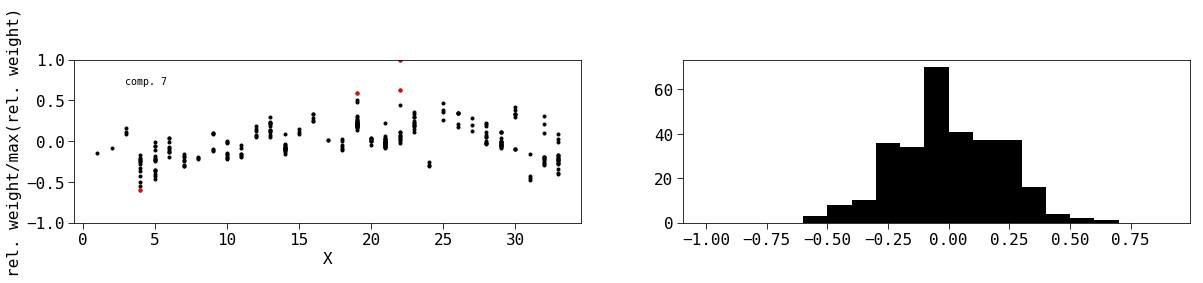

Exceptional weights for component 7:  [2018031600701 2018031600702 2018031600703 2018031600801 2018031600802
 2018031600803]


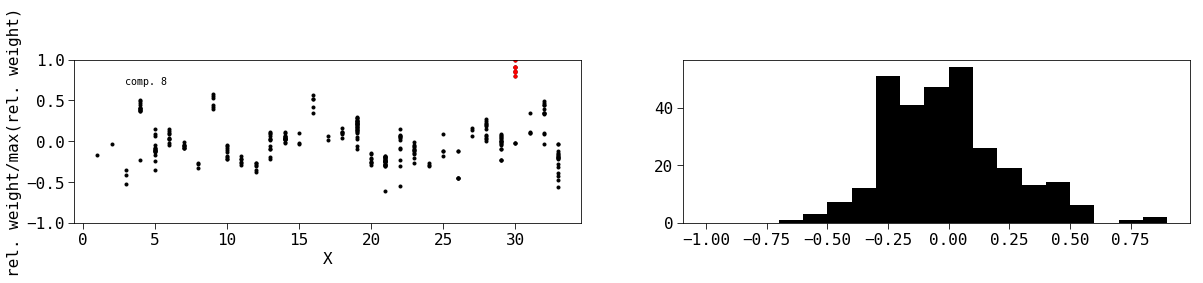

Exceptional weights for component 8:  [2018011300603 2018022201702 2018022301701 2018022301702 2018022301703
 2018032001501 2018032001502 2018032001503 2018032102602 2018032102603]


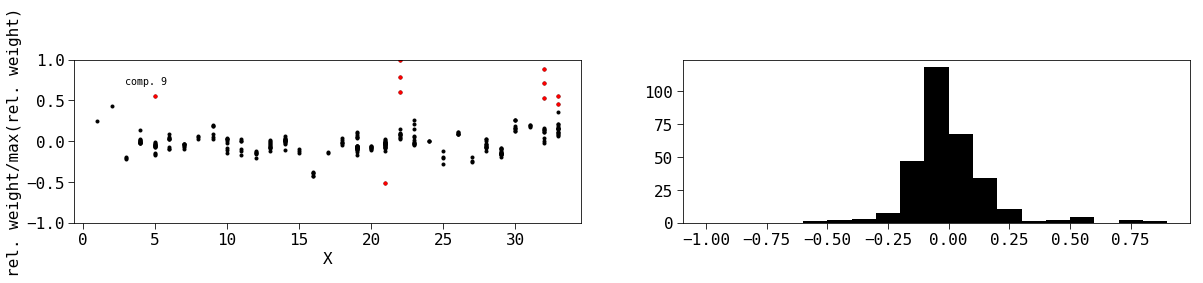

Exceptional weights for component 9:  [2018011300603 2018022201702 2018022301703]


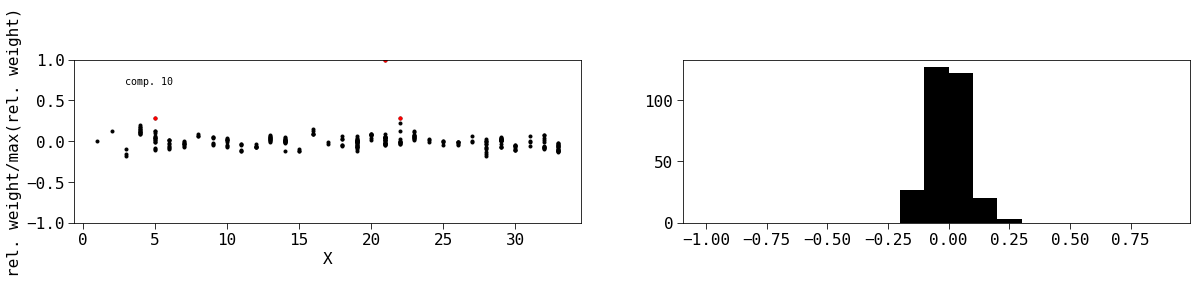

Exceptional weights for component 10:  [2018011300603 2018021101803]


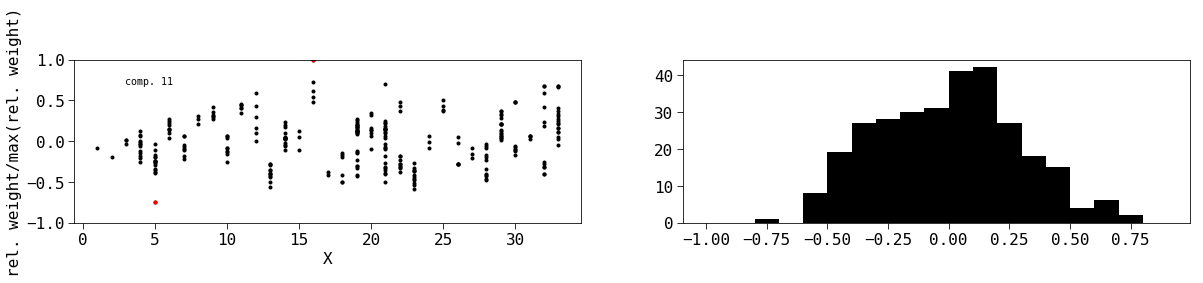

Exceptional weights for component 11:  [2018011300603 2018021101701 2018021101702 2018021101703 2018021101801
 2018021101803 2018022201702]


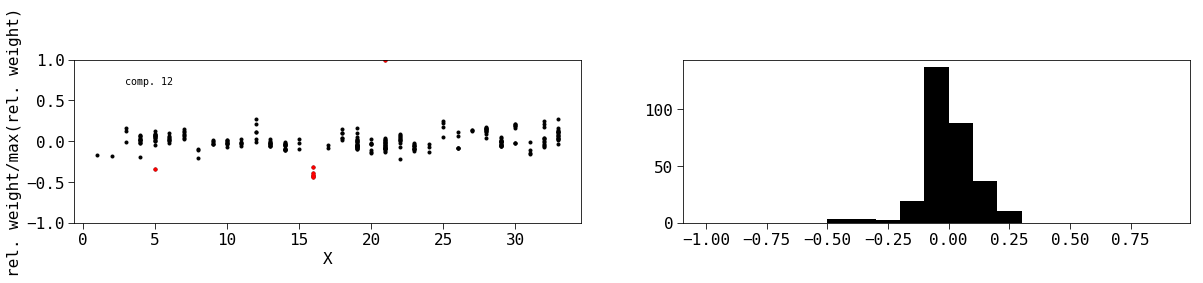

Exceptional weights for component 12:  [2018022201702 2018022301702 2018022301703 2018031901501 2018031901502]


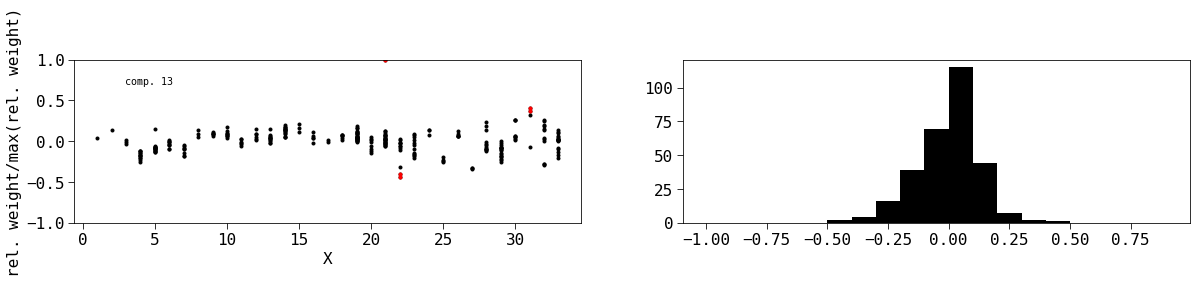

Exceptional weights for component 13:  [2018011300603 2018020700802 2018020700803 2018022201702 2018022301703
 2018031000603 2018031000701 2018031000702 2018031000703 2018032102601
 2018032102602 2018032102603]


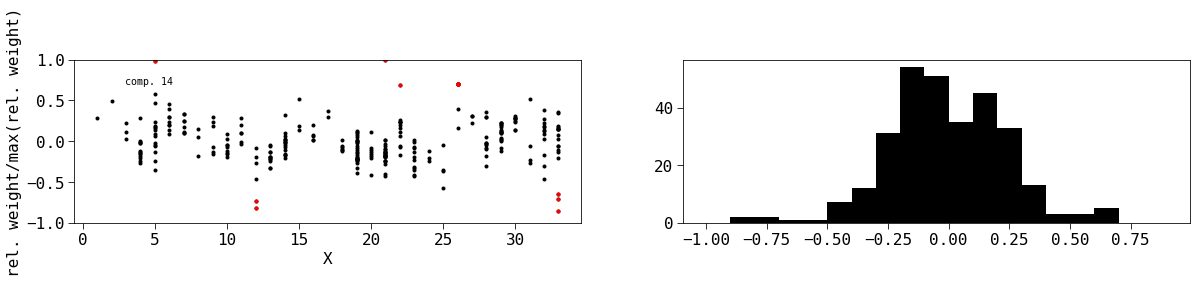

Exceptional weights for component 14:  [2018011300603 2018020700802 2018020700803 2018022201702 2018031000601
 2018031000602 2018032001503]


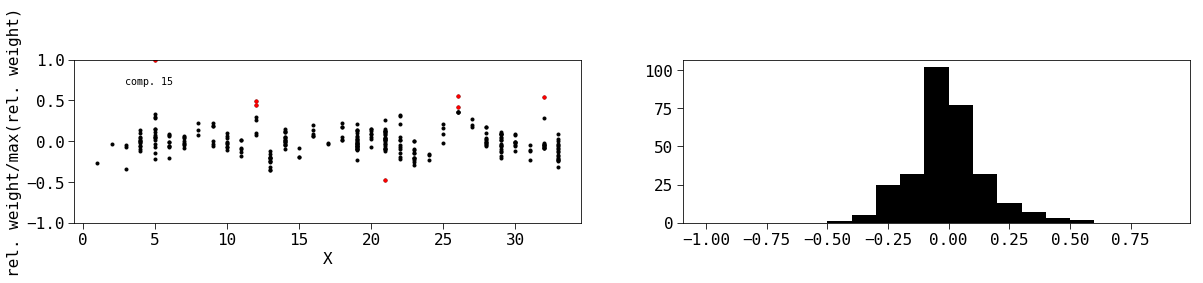

Exceptional weights for component 15:  [2018011901601 2018022301202 2018022301703 2018030900401 2018031901503]


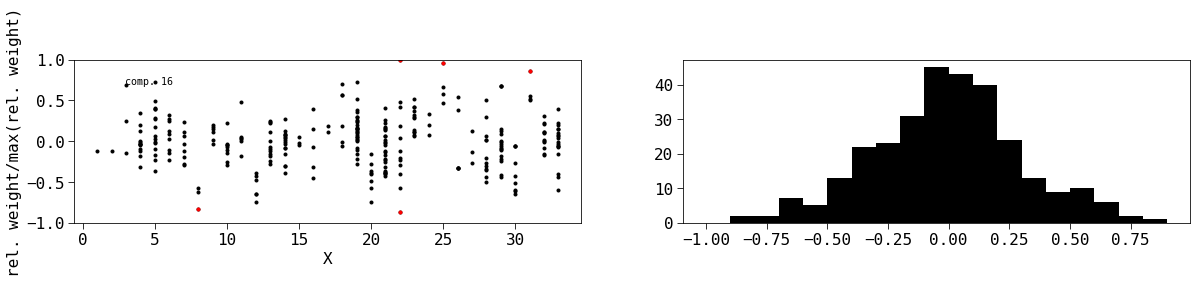

Exceptional weights for component 16:  [2018010600503 2018010700301 2018011200703 2018022301702 2018022301703]


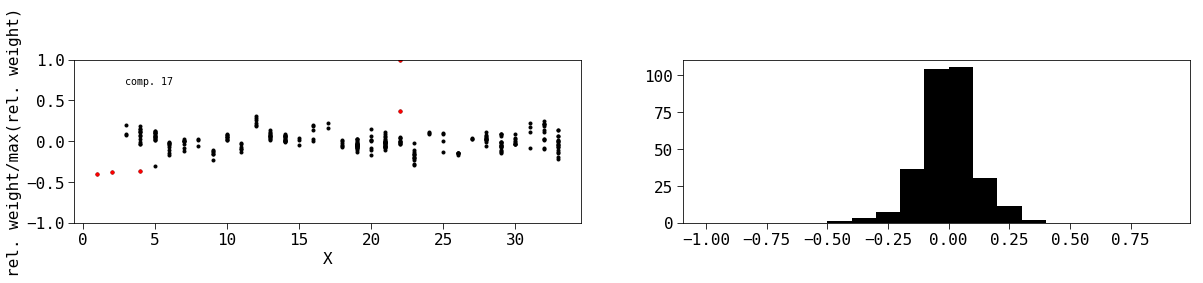

Exceptional weights for component 17:  [2018011300603 2018020700802 2018020700803 2018021501502 2018031000601
 2018031000602 2018031100903 2018031201003]


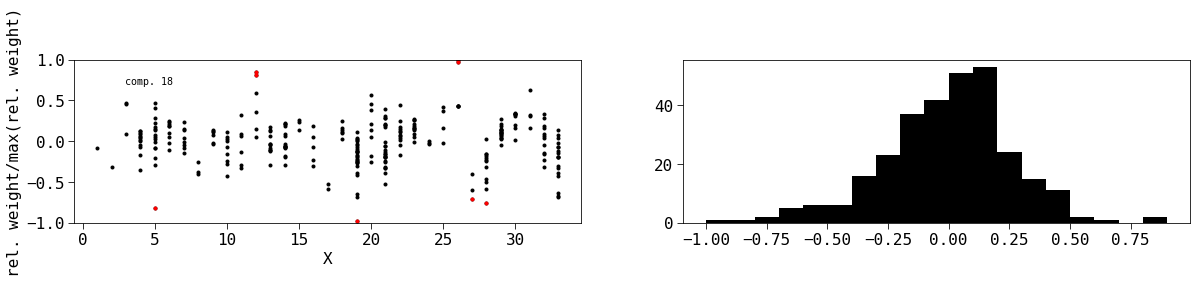

Exceptional weights for component 18:  [2018010700301 2018011300603 2018020801102 2018021600902 2018021600903
 2018021601001 2018022301703]


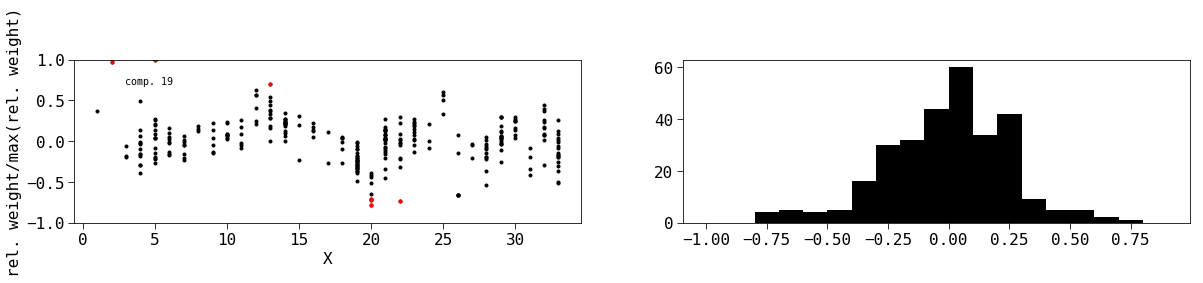

Exceptional weights for component 19:  [2018012000902 2018021501403 2018032101101 2018032101302]


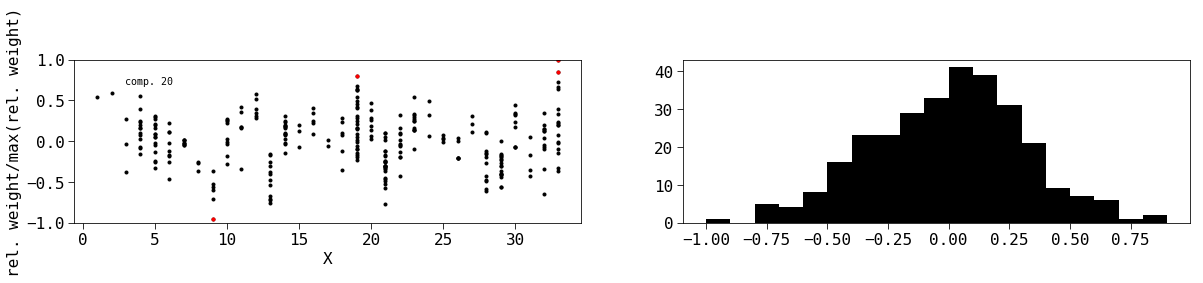

Exceptional weights for component 20:  [2018020900803 2018030900401 2018031901301]


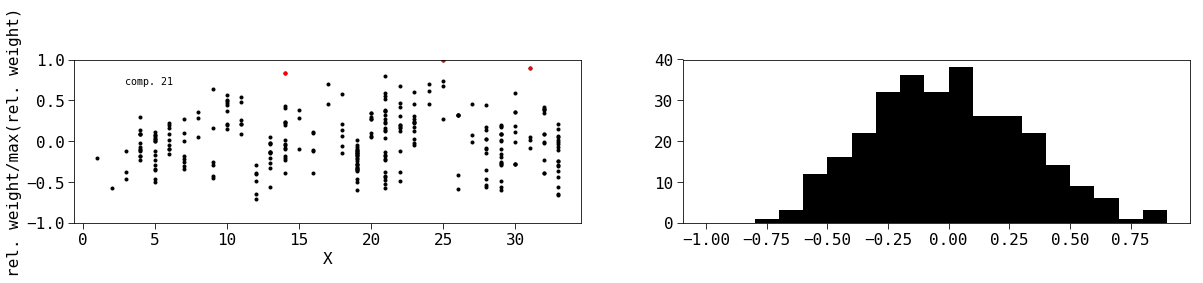

Exceptional weights for component 21:  [2018010700301 2018011300603 2018031901502]


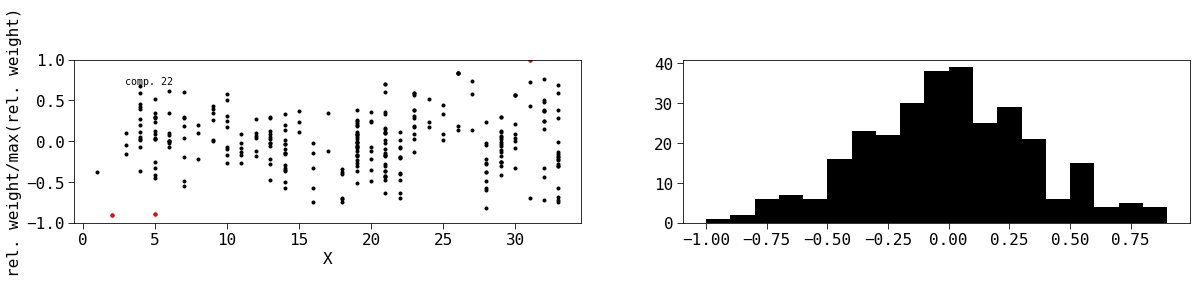

Exceptional weights for component 22:  [2018010600503 2018011002103 2018011300603 2018022301702 2018031201402
 2018032001503]


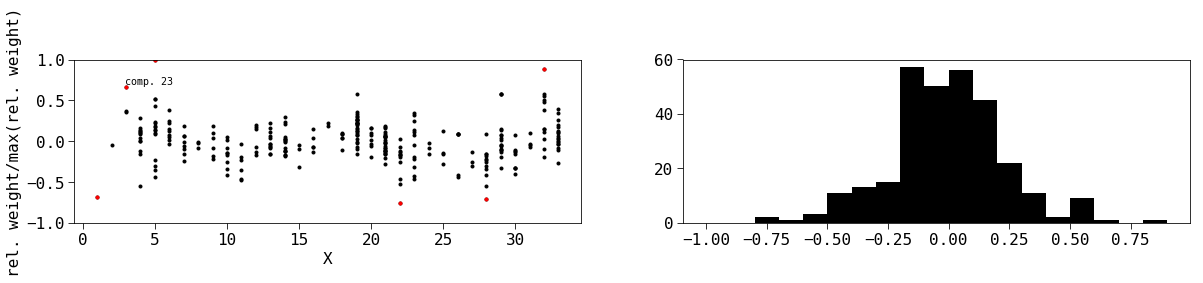

Exceptional weights for component 23:  [2018011002103 2018022201101 2018032000801 2018032000803]


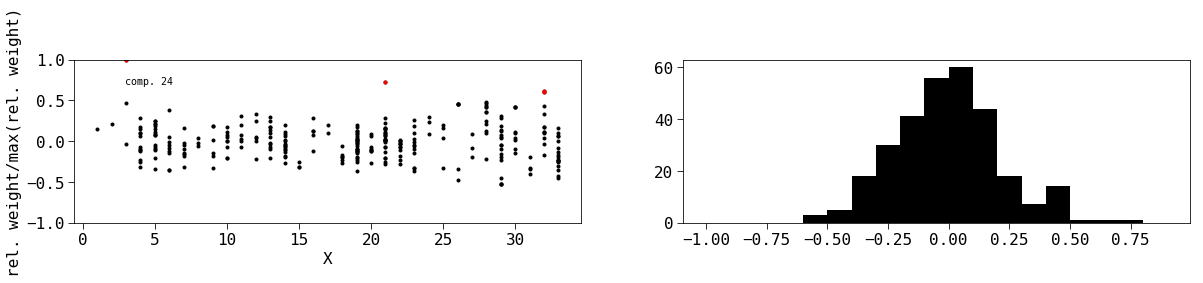

Exceptional weights for component 24:  [2018010700301 2018021601002 2018031601501 2018031601502 2018031601503
 2018031901301]


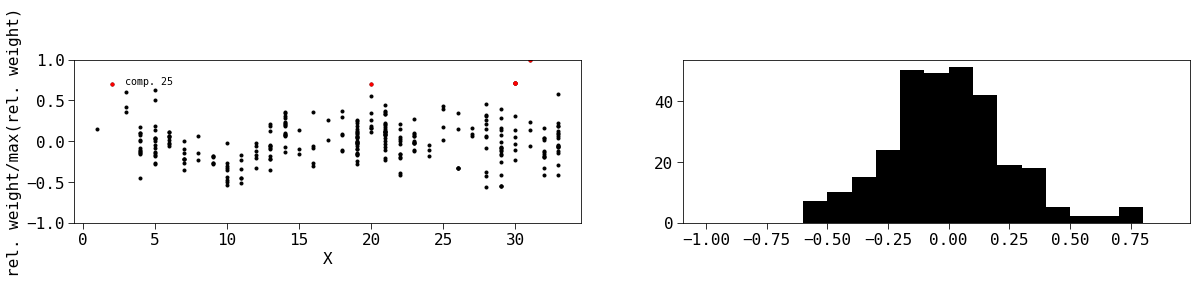

In [28]:
kappa = 2.5

Ncomp = tA.shape[1]

for i in range(Ncomp):
    y = tA[:,i]/np.max(tA[:,i])
    f = plt.figure(figsize=[20,3])
    ax = plt.subplot(121)
    plt.plot(x, y,'.')
    plt.ylabel("rel. weight/max(rel. weight)")
    plt.xlabel("X")
    plt.ylim([-1.,1.])
    
    plt.text(.1,.9,"comp. {}".format(i+1), transform=ax.transAxes,ha="left",va="top")
    
    sigma = np.std(y)
    ll = np.abs(y) >= kappa * sigma
    plt.plot(x[ll], y[ll],'r.')
    
    
    plt.subplot(122)
    plt.hist(y,bins=np.arange(-1.,1.,.1))
    
    print("Exceptional weights for component {}: ".format(i), np.sort( shotNumA[ll])) 
    
    if False:
        for s in shotNumA[ll]:
            shot = str(s)[:-5] + "v" + str(s)[-5:-2]
            exp = 'exp' + str(s)[-2:]
            #shot, exp = '20180104v007', 'exp01'
            print(shot, exp)
            #sys.exit(1)
            plotSpec(skys, IFU, amp, shot, exp)

    plt.show()
    
    
    
    

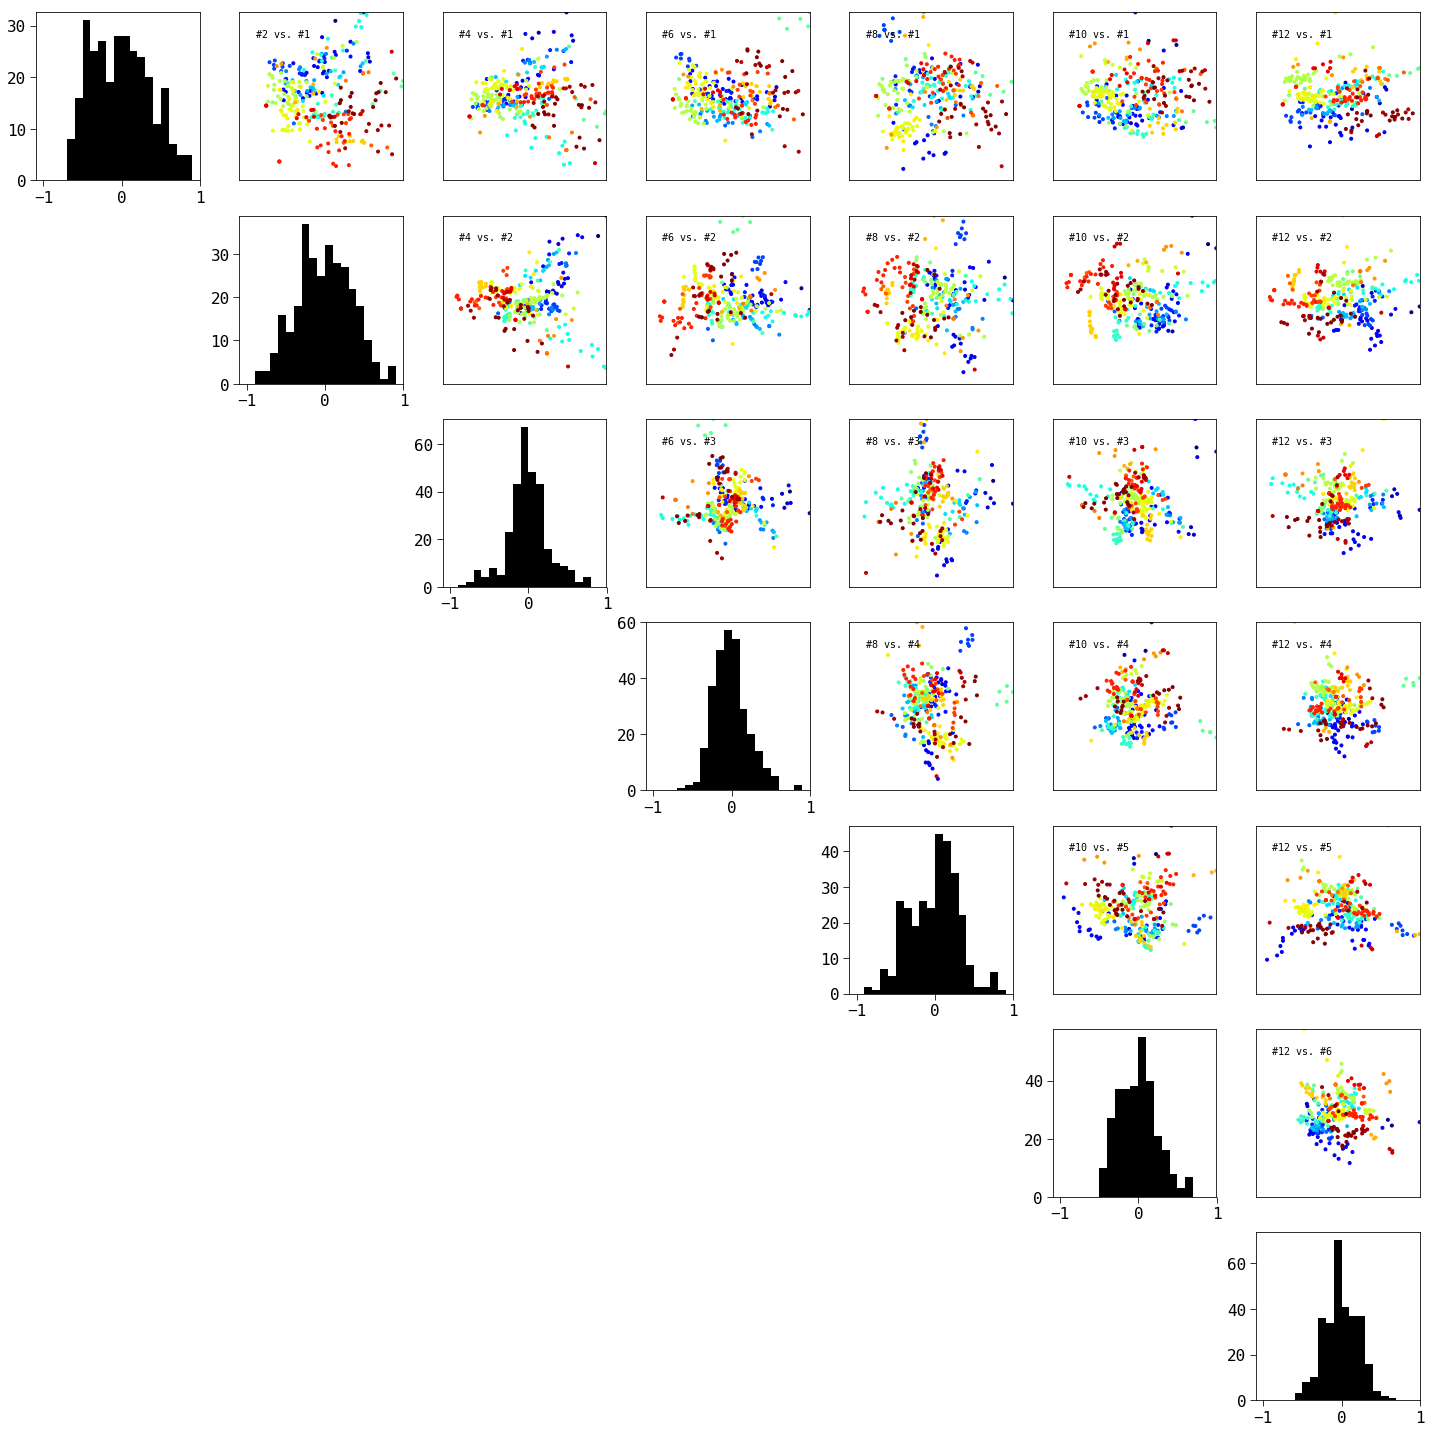

In [29]:
import sys
f = plt.figure(figsize=[20,20])
cnt = 1

Ncomp = 7

cmap = plt.cm.jet
color =  (x-np.min(x))/(np.max(x)-np.min(x))

for i in range(Ncomp):

    for j in range(i,Ncomp):
        pos = j%Ncomp + i*Ncomp + 1
        #print(pos)
        ax = plt.subplot(Ncomp,Ncomp, pos)
        
        y1 = tA[:,i]/np.max(tA[:,i])
        y2 = tA[:,j]/np.max(tA[:,j])
        
        if i == j:
                plt.hist(y1,bins=np.arange(-1.,1.,.1))
                #print("Excpetional weights for component {}: ".format(i), shotNumA[ll])
                #plt.show()
        
        else:
            plt.scatter(y1,y2,color=cmap(color), marker='.')
            #plt.xlabel("#{}".format(i+1))
            #plt.ylabel("#{}".format(j+1))
            plt.xlim([-1,1])
            plt.ylim([-1,1])
            plt.xticks([])
            plt.yticks([])
            plt.text(.1,.9,"#{} vs. #{}".format(j+j,i+1), transform=ax.transAxes,ha="left",va="top")
        
        cnt = cnt + 1
f.tight_layout()